In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import plotnine as p9
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import warnings

warnings.filterwarnings("ignore")
sys.path.insert(0, "../0.data-download/scripts/")
from data_loader import load_data, load_train_test_data

In [2]:
# data path
data_directory = "../0.data-download/data/"

In [3]:
# load the training data
dfs_test, dfs, data = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=False
)

In [4]:
# set a unique dataframe that can be appended from
training_df_age = dfs

# group by age and create new dataframes that can be appended to
groups = training_df_age.groupby("age_and_sex")
adult_effect_df = pd.DataFrame()
ped_effect_df = pd.DataFrame()
for name, training_df_age in groups:

    # append rows that contain Adult samples (male or female) to the new adult effect dataframe
    if name == "Adult_Male" or name == "Adult_Female" or name == "Adult_nan":
        adult_effect_df = adult_effect_df.append(training_df_age)
        adult_effect_df = adult_effect_df.reset_index(drop=True)

    # append rows that contain Pediatric samples (male ore female) to the new pediatric dataframe
    else:
        ped_effect_df = ped_effect_df.append(training_df_age)
        ped_effect_df = ped_effect_df.reset_index(drop=True)

In [5]:
# set a unique dataframe that can be appended from
training_df_sex = dfs

# group by sex and create new dataframes to be appended to
groups_sex = training_df_sex.groupby("age_and_sex")
male_effect_df = pd.DataFrame()
female_effect_df = pd.DataFrame()
for name, training_df_sex in groups_sex:

    # append rows that contain Male samples (Adult or Pediatric) to the new male effect dataframe and filter out samples that contain no gender info
    if (
        name == "Adult_Male"
        or name == "Pediatric_Male"
        and name != "Pediatric_nan"
        and name != "Adult_nan"
    ):
        male_effect_df = male_effect_df.append(training_df_sex)
        male_effect_df = male_effect_df.reset_index(drop=True)

    # append rows that contain Female samples (Adult or Pediatric) to the new female effect dataframe and filter out samples that contain no gender info
    elif (
        name == "Adult_Female"
        or name == "Pediatric_Female"
        and name != "Pediatric_nan"
        and name != "Adult_nan"
    ):
        female_effect_df = female_effect_df.append(training_df_sex)
        female_effect_df = female_effect_df.reset_index(drop=True)

In [6]:
print(adult_effect_df.shape)
adult_effect_df.head(3)

(116, 17204)


,ModelID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009),age_and_sex
0,ACH-002508,0.455775,0.611546,0.651625,0.518558,0.417817,0.477771,0.532775,0.475233,0.661932,...,0.697598,0.486749,0.832748,0.295948,0.454446,0.657200,0.419787,0.478215,0.780292,Adult_Female
1,ACH-001274,0.424179,0.698891,0.563686,0.642528,0.652363,0.634394,0.540785,0.682024,0.588516,...,0.483570,0.365071,0.331586,0.504603,0.505910,0.472046,0.713701,0.537723,0.603171,Adult_Female
2,ACH-000145,0.541070,0.553952,0.650555,0.622135,0.491837,0.699190,0.276335,0.569152,0.698287,...,0.613954,0.385185,0.518662,0.538405,0.336252,0.371619,0.477322,0.679666,0.485491,Adult_Female


In [7]:
print(ped_effect_df.shape)
ped_effect_df.head(3)

(21, 17204)


,ModelID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009),age_and_sex
0,ACH-000884,0.485434,0.562608,0.396539,0.580647,0.711524,0.458991,0.545970,0.607741,0.699174,...,0.327599,0.629105,0.500968,0.569503,0.541298,0.633879,0.439291,0.683263,0.536255,Adult_Unknown
1,ACH-001374,0.703654,0.633594,0.606901,0.776867,0.319017,0.493260,0.837580,0.724729,0.792895,...,0.536254,0.521098,0.631561,0.236817,1.000000,0.526025,0.698974,0.231805,0.552953,Pediatric_Female
2,ACH-000922,0.368074,0.640051,0.531879,0.478603,0.587522,0.747465,0.497355,0.425294,0.688137,...,0.467171,0.596746,0.714422,0.158566,0.366919,0.637048,0.340935,0.654767,0.487979,Pediatric_Female


In [8]:
print(male_effect_df.shape)
male_effect_df.head(3)

(77, 17204)


,ModelID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009),age_and_sex
0,ACH-002189,0.511344,0.415070,0.452344,0.472997,0.472125,0.554615,0.512139,0.623792,0.730746,...,0.164927,0.623615,0.590029,0.548699,0.333368,0.641548,0.502526,0.489526,0.436068,Adult_Male
1,ACH-002249,0.435182,0.674764,0.691628,0.568022,0.780051,0.779701,0.572729,0.634688,0.667900,...,0.412075,0.418333,0.626111,0.608158,0.286185,0.558428,0.497973,0.685813,0.581211,Adult_Male
2,ACH-001685,0.462000,0.667725,0.503904,0.473175,0.761452,0.402295,0.472169,0.350551,0.670204,...,0.190616,0.396307,0.639766,0.562563,0.507771,0.577380,0.493748,0.301653,0.566779,Adult_Male


In [9]:
print(female_effect_df.shape)
female_effect_df.head(3)

(58, 17204)


,ModelID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009),age_and_sex
0,ACH-002508,0.455775,0.611546,0.651625,0.518558,0.417817,0.477771,0.532775,0.475233,0.661932,...,0.697598,0.486749,0.832748,0.295948,0.454446,0.657200,0.419787,0.478215,0.780292,Adult_Female
1,ACH-001274,0.424179,0.698891,0.563686,0.642528,0.652363,0.634394,0.540785,0.682024,0.588516,...,0.483570,0.365071,0.331586,0.504603,0.505910,0.472046,0.713701,0.537723,0.603171,Adult_Female
2,ACH-000145,0.541070,0.553952,0.650555,0.622135,0.491837,0.699190,0.276335,0.569152,0.698287,...,0.613954,0.385185,0.518662,0.538405,0.336252,0.371619,0.477322,0.679666,0.485491,Adult_Female


In [10]:
# drop the string values from all dataframes
adult_effect_df_float = adult_effect_df.drop(
    columns=["ModelID", "age_and_sex"]
)
ped_effect_df_float = ped_effect_df.drop(columns=["ModelID", "age_and_sex"])

male_effect_df_float = male_effect_df.drop(columns=["ModelID", "age_and_sex"])
female_effect_df_float = female_effect_df.drop(
    columns=["ModelID", "age_and_sex"]
)

effect_df = dfs.drop(columns="age_and_sex")
effect_df = effect_df.set_index("ModelID")

In [11]:
# t_test comparing gene dependencies in adult vs pediatric samples
t_test = ttest_ind(adult_effect_df_float, ped_effect_df_float)
t_test = pd.DataFrame(t_test).T
t_test.columns = ["t_stat", "p_value"]
print(t_test.shape)
t_test.head(3)

(17202, 2)


,t_stat,p_value
0,-0.251322,0.801947
1,-1.894969,0.060235
2,-2.312071,0.022287


In [12]:
# t_test comparing gene dependencies in male vs female samples
t_test_sex = ttest_ind(male_effect_df_float, female_effect_df_float)
t_test_sex = pd.DataFrame(t_test_sex).T
t_test_sex.columns = ["t_stat", "p_value"]
print(t_test_sex.shape)
t_test_sex.head(3)

(17202, 2)


,t_stat,p_value
0,1.124673,0.262753
1,-0.176654,0.860049
2,0.341576,0.733209


In [13]:
print(effect_df.shape)
effect_df.head(3)

(137, 17202)


,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),AADAC (13),...,ZWILCH (55055),ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009)
ModelID,,,,,,,,,,,,,,,,,,,,,
ACH-002189,0.511344,0.415070,0.452344,0.472997,0.472125,0.554615,0.512139,0.623792,0.730746,0.441548,...,0.667496,0.164927,0.623615,0.590029,0.548699,0.333368,0.641548,0.502526,0.489526,0.436068
ACH-002508,0.455775,0.611546,0.651625,0.518558,0.417817,0.477771,0.532775,0.475233,0.661932,0.486369,...,0.755518,0.697598,0.486749,0.832748,0.295948,0.454446,0.657200,0.419787,0.478215,0.780292
ACH-002249,0.435182,0.674764,0.691628,0.568022,0.780051,0.779701,0.572729,0.634688,0.667900,0.468080,...,0.506229,0.412075,0.418333,0.626111,0.608158,0.286185,0.558428,0.497973,0.685813,0.581211


In [14]:
# calculate variance of each gene then send the results plus the gene info into a new dataframe
variance = effect_df.var()
variance_list = variance.tolist()
column_names = ["variance"]
variance_df = pd.DataFrame(variance, columns=column_names)
variance_df = variance_df.sort_index(ascending=True).reset_index()
variance_df = variance_df.rename(columns={"index": "gene_ID"})
print(variance_df.shape)
variance_df.head(3)

(17202, 2)


,gene_ID,variance
0,A1BG (1),0.010703
1,A1CF (29974),0.007057
2,A2M (2),0.014677


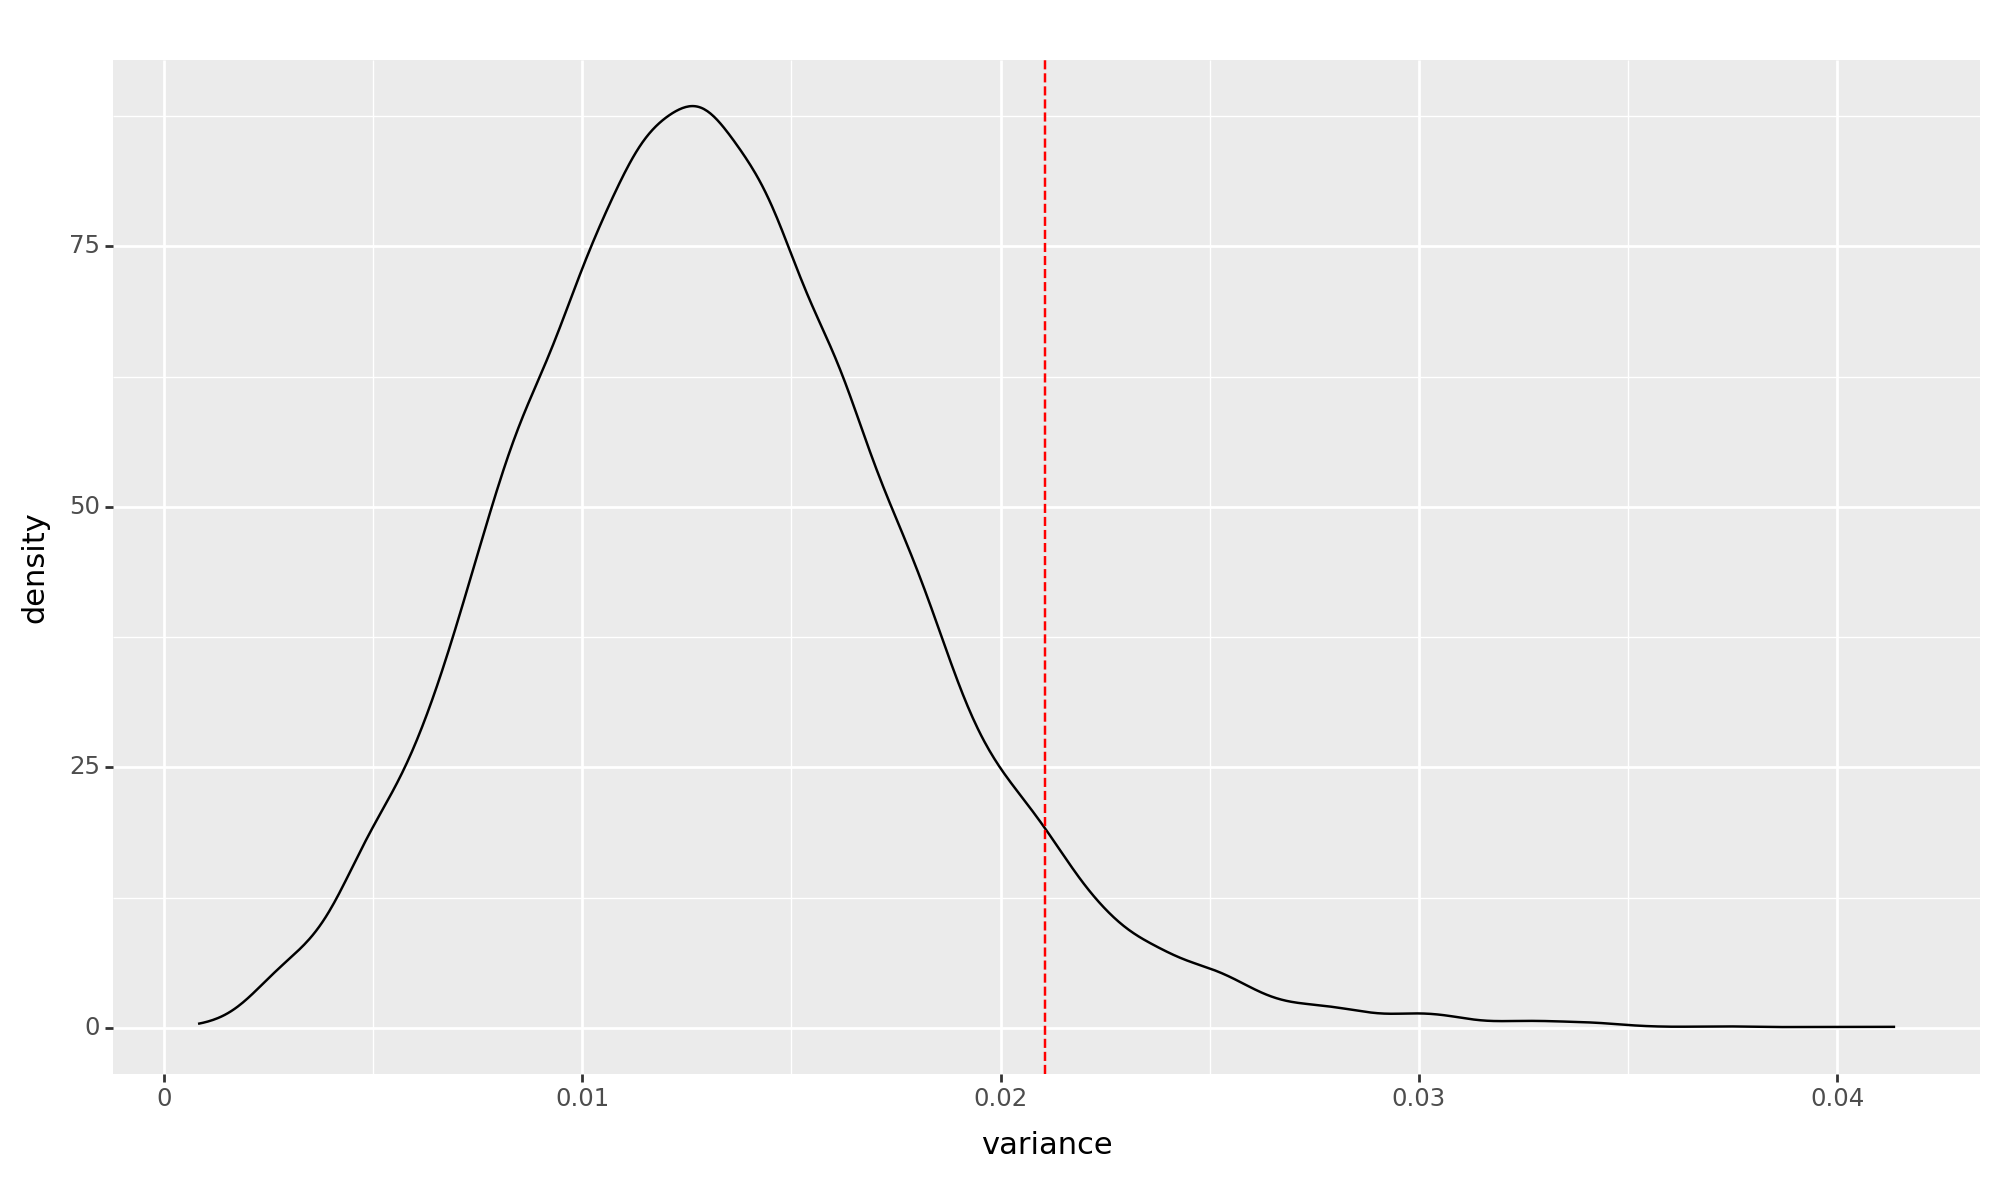

<Figure Size: (1000 x 600)>

In [15]:
# finding the smallest gene variation out of the 1000 largest gene variations to set the top 1000 gene variances threshold
n = variance_df["variance"].nlargest(1000)
variance_theshold = n.astype(float).min()

# plotting variance density chart and marking the 1000 largest gene variation cutoff
variance_density_plot = (
    p9.ggplot(variance_df, p9.aes(x="variance"))
    + p9.geom_density()
    + p9.geom_vline(xintercept=variance_theshold, linetype="dashed", color="red")
    + p9.theme(figure_size=(10, 6))
)

# save the figure
density_path = pathlib.Path("./figures/variance_density_plot.png")
variance_density_plot.save(density_path)
variance_density_plot

In [16]:
# first create new dataframe containing gene info as well as both adult-pediatric and male-female t-test results and variance results
df = variance_df.assign(
    ttest_A_vs_P=t_test.t_stat.astype(float),
    ttest_M_vs_F=t_test_sex.t_stat.astype(float),
)

# and save the new dataframe as a .csv
testing_df_output = pathlib.Path(
    "../0.data-download/data/genes_variances_and_t-tests_df.csv"
)
df.to_csv(testing_df_output, index=False)
print(df.shape)
df.head(3)

(17202, 4)


,gene_ID,variance,ttest_A_vs_P,ttest_M_vs_F
0,A1BG (1),0.010703,-0.251322,1.124673
1,A1CF (29974),0.007057,-1.894969,-0.176654
2,A2M (2),0.014677,-2.312071,0.341576


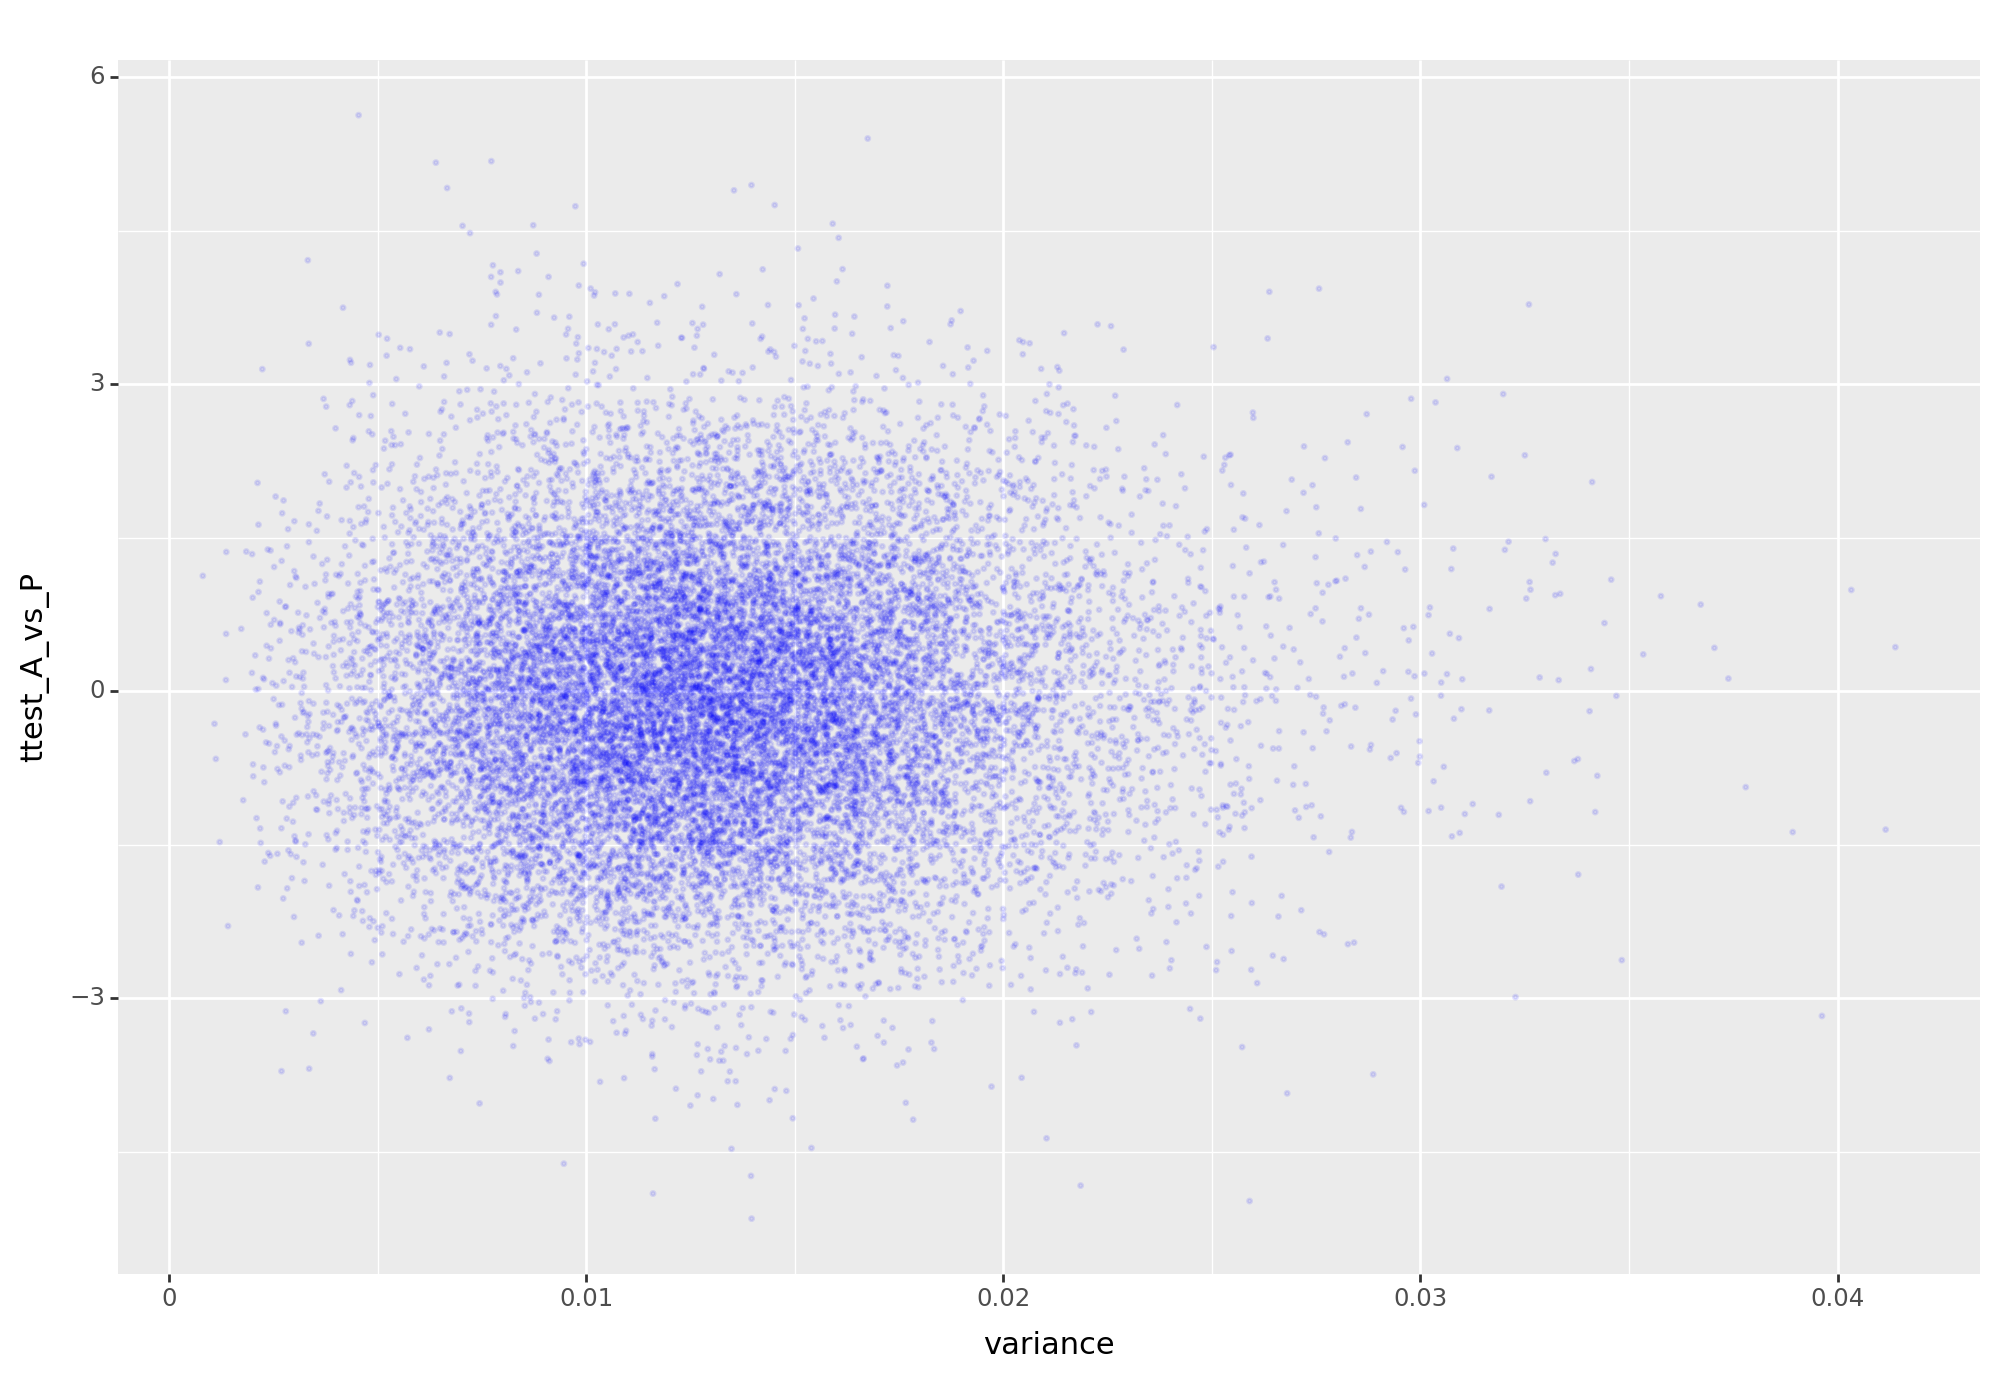

<Figure Size: (1000 x 700)>

In [17]:
# plot adult-pediatric ttest versus variance
A_vs_P_by_variance_plot = (
    p9.ggplot(data=df, mapping=p9.aes(x="variance", y="ttest_A_vs_P"))
    + p9.geom_point(size=0.4, alpha=0.1, color="blue")
    + p9.theme(figure_size=(10, 7))
)

# save the figure
adult_vs_pediatric_path = pathlib.Path(
    "./figures/adult-pediatric_ttest_vs_variance.png"
)
A_vs_P_by_variance_plot.save(adult_vs_pediatric_path)
A_vs_P_by_variance_plot

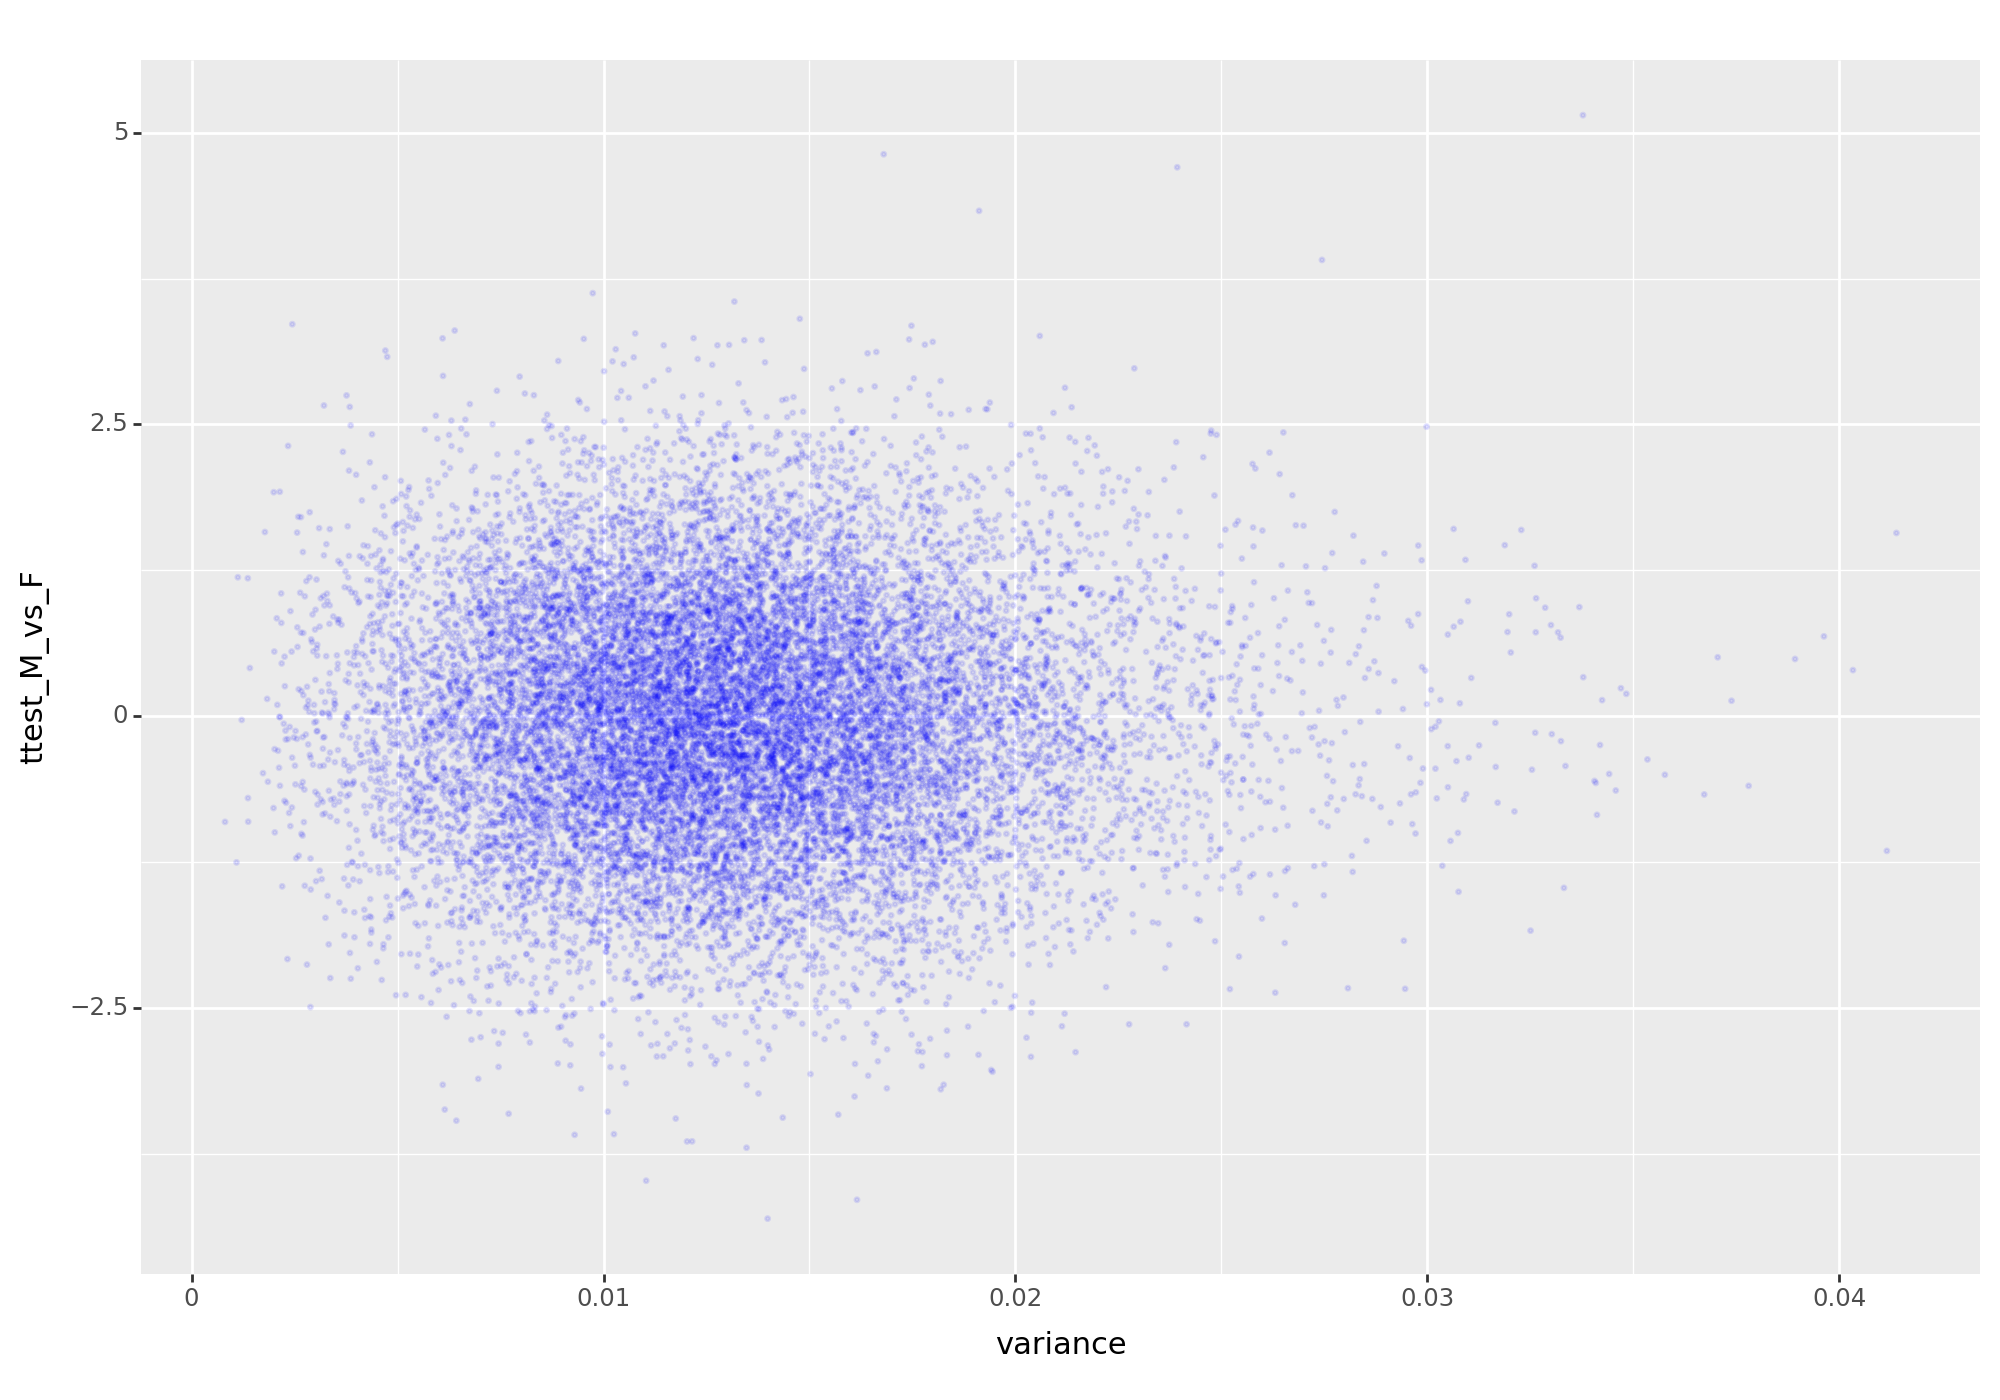

<Figure Size: (1000 x 700)>

In [18]:
# plot male-female ttest versus gene variance
M_vs_F_by_variance_plot = (
    p9.ggplot(data=df, mapping=p9.aes(x="variance", y="ttest_M_vs_F"))
    + p9.geom_point(size=0.4, alpha=0.1, color="blue")
    + p9.theme(figure_size=(10, 7))
)

# save the figure
male_vs_female_path = pathlib.Path("./figures/male-female_ttest_vs_variance.png")
M_vs_F_by_variance_plot.save(male_vs_female_path)
M_vs_F_by_variance_plot